In [1]:
import PIL
import os
import logging
import pickle as pk
from collections import defaultdict

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from patchify import patchify,unpatchify

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

logging.getLogger("PIL").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

PIL.Image.MAX_IMAGE_PIXELS = 933120000

import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader
from torchvision.models.resnet import resnet50, ResNet50_Weights

In [2]:
class MapPatch():
    def __init__(self, patch, patch_index, origin_map):
        self.patch = patch
        self.patch_index = patch_index
        self.origin_map = origin_map
        
    @staticmethod
    def get_map_patches(file_name, patch_width, map_transformer = None, verbose = True):
        tif_map = PIL.Image.open(file_name)
        tif_map_np = np.array(tif_map)
        
        if map_transformer is not None and verbose:
            logging.info(f"Applying transformation {map_transformer.__name__} to {file_name}")
            tif_map_np = map_transformer(tif_map_np)
        
        tif_map_patches = patchify(image = tif_map_np, 
                                   patch_size = (patch_width, patch_width, 3),
                                   step = patch_width)

        if verbose:
            logging.info(f"{np.prod(tif_map_patches.shape[:2]):,} patches from {file_name} generated with shape {tif_map_patches.shape}")

        return tif_map_np, tif_map_patches
    
    @staticmethod
    def get_map_patch_list(file_name, patch_width, map_transformer = None, verbose = True):
        _, tif_map_patches = MapPatch.get_map_patches(file_name, 
                                                      patch_width, 
                                                      map_transformer = map_transformer, 
                                                      verbose = verbose)
        patches = []
        
        for i in range(tif_map_patches.shape[0]):
            for j in range(tif_map_patches.shape[1]):
                patches.append(MapPatch(tif_map_patches[i,j,0], patch_index = (i,j), origin_map = file_name))
                
        return patches
    
    def show(self, verbose = True):
        fig, ax = plt.subplots()
        ax.imshow(self.patch)
        
        if verbose:
            ax.set_title(f"Patch at {self.patch_index} from {self.origin_map}.")
            
        plt.show()

In [3]:
class PatchDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, i):
        if isinstance(i, slice):
            start = i.start if i.start else 0
            stop = i.stop if i.stop else len(self.patches)
            step = i.step if i.step else 1
            
            return [(self.patches[j], self.patches[j].origin_map) for j in range(start, stop, step)]
        
        return (self.patches[i], self.patches[i].origin_map)
    
    @classmethod
    def from_dir(cls, directory, file_ext, patch_width, map_transformer = None):
        patches = []
        
        if file_ext == "tif":
            for file in os.listdir(directory):
                if file.endswith("tif"):
                    file_name = f"{directory}/{file}"
                    logging.info(f"Fetching patches from {file_name}.")
                    patches.extend(MapPatch.get_map_patch_list(file_name = file_name, 
                                                               patch_width = patch_width, 
                                                               map_transformer = map_transformer,
                                                               verbose = True))
        elif file_ext == "pk":
            for file in os.listdir(directory):
                if file.endswith("pk"):
                    file_name = f"{directory}/{file}"
                    logging.info(f"Fetching patches from {file_name}.")
                    with open(file_name, "rb") as f:
                        patches.extend(pk.load(file_name))
        else:
            print(f"{file_ext} is an invalid file format. Require tif or pk.")
            
        return cls(patches)
    
    def to_pickle(self, file_name = None):
        with open(f"{file_name}.pk", "wb") as f:
            pk.dump(self.patches, f)

In [4]:
# transformations to apply to the map

def max_pooler(img, kernel_size):
    return block_reduce(img, block_size = (kernel_size, kernel_size,1), func = np.max)

def min_pooler(img, kernel_size):
    return block_reduce(img, block_size = (kernel_size, kernel_size,1), func = np.min)

def med_reduce(x, axis):
    return np.median(x,axis).astype(np.int32)

def med_pooler(img, kernel_size):
    return block_reduce(img, block_size = (kernel_size, kernel_size,1), func = med_reduce)

def mean_reduce(x, axis):
    return np.mean(x,axis).astype(np.int32)

def mean_pooler(img, kernel_size):
    return block_reduce(img, block_size = (kernel_size, kernel_size,1), func = mean_reduce)

def torch_downsample(img, kernel_size, interpolation = InterpolationMode.BILINEAR):
    size = img.shape
    
    new_size = (size[0]//kernel_size, size[1]//kernel_size)
    
    tensor_img = np.moveaxis(img, -1, 0)
    tensor_img = torch.Tensor(tensor_img)
    
    resized_map = T.Resize(new_size, interpolation=interpolation)(tensor_img)
    
    resized_map = resized_map.numpy()
    resized_map = np.moveaxis(resized_map, 0, -1)
    
    return resized_map.astype(int)

def bilinear_interpolator(img, kernel_size):
    return torch_downsample(img, kernel_size, interpolation = InterpolationMode.BILINEAR)

def bicubic_interpolator(img, kernel_size):
    return torch_downsample(img, kernel_size, interpolation = InterpolationMode.BICUBIC)

NameError: name 'InterpolationMode' is not defined

In [ ]:
def bilinear_interpolator_4x4(img):
    return bilinear_interpolator(img, 4)

patch_dataset = PatchDataset.from_dir("data", 
                                       file_ext = "tif", 
                                       patch_width = 64, 
                                       map_transformer= bilinear_interpolator_4x4)
                           

In [28]:
class MapCLNN(nn.Module):
    def __init__(self, positive_samples):
        super(MapCLNN, self).__init__()
        
        self.MAX_PIXEL_VALUE = 255
        self.RESNET_DIM = 224
        
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # dictionary containing patch alignments
        # key is a tuple, representing the patch coordinates of the patch
        # value is a list, containing MapPatch instances
        # MapPatch instances with the same key can be thought of as positive samples for the algorithm
        self.positive_samples = positive_samples
    
    def img_to_resnet(self, img, dim = 224):
        """
        Convert image into the desired format for ResNet.
        The image must have width and height of at least self.RESNET_DIM, with RGB values between 0 and 1.
        Moreover, it must be normalised, by using a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225]
        --------------------------------------------------------------------------------------------------------------------------------
        :param img: a numpy nd.array, with 3 colour channels (this must be stored in the last dimensions), which has to be fed to ResNet
        :param dim: the desired dimension of the image (if we want to resize img before feeding it to ResNet).
                    This should be at least self.RESTNET_DIM.
        --------------------------------------------------------------------------------------------------------------------------------
        :return a Tensor, with the first dimension corresponding to the RGB channels, and normalised to be used by ResNet.
        """
        
        assert dim >= self.RESNET_DIM, f"Provided dimension {dim} is less than the required for RESNET ({self.RESNET_DIM})"
        
        # put the colour channel in front
        norm_img = np.moveaxis(img, -1, 0)
        
        # normalise into range [0,1]
        norm_img = torch.from_numpy(norm_img)/255
        
        # resize
        if img.shape[0] < self.RESNET_DIM or img.shape[1] < self.RESNET_DIM:
            norm_img = T.Resize(self.RESNET_DIM)(norm_img)
        else:
            if dim is not None:
                norm_img = T.Resize(dim)(norm_img)     
        
        # normalise mean and variance
        mean = torch.Tensor([0.485, 0.456, 0.406])
        std = torch.Tensor([0.229, 0.224, 0.225])
        
        return T.Normalize(mean = mean, std = std)(norm_img)
    
    def sim(self, z_i, z_j):
        """
        Computes cosine similarity between 2 vectors z_i, z_j.
        """
        return torch.dot(z_i,z_j)/(torch.linalg.norm(z_i) * torch.linalg.norm(z_j))
    
    def exp_sim(self, z_i, z_j, tau):
        """
        Computes a temperature-scaled, exponential similarity between 2 vectors z_i, z_j
        """
        return torch.exp(self.sim(z_i, z_j)/tau)
    
    def sample_contrastive_loss(self, z_i, z_j, z_batch, tau):
        """
        Computes the contrastive loss for a pair of positive samples z_i, z_j.
        -----------------------------------------------------------------------
        :param z_i,z_j: 1D Tensors; these are positive samples whose loss we compute.
        :param z_batch: a 2D Tensor, giving the batch over which we compute the loss. Contains the negative samples for z_i,z_j.
        :param tau: a float, the "temperature"
        """
        similarity = self.exp_sim(z_i, z_j, tau)
        all_dissimilarities = [self.exp_sim(z_i, z_k, tau) for z_k in neg_samples if not torch.equal(z_i,z_k)]
        dissimilarity = torch.sum(torch.Tensor(all_dissimilarities))
        
        return -torch.log(similarity/dissimilarity)
    
    def contrastive_loss(self, z_batch, tau, n_augs = 2):
        N = len(z_batch)
        
        all_losses = [self.sample_contrastive_loss(z_batch[2*k + 1], z_batch[2*k+2], z_batch, tau) +
                      self.sample_contrastive_loss(z_batch[2*k+2], z_batch[2*k + 1], z_batch, tau)
                      for k in range(1,N + 1)]
        
        return 1/(n_augsN) * torch.sum(torch.Tensor(all_losses))
    
    def forward(self,x):
        pass
    
    def compile_model(self):
        pass
    
    def train(self):
        pass

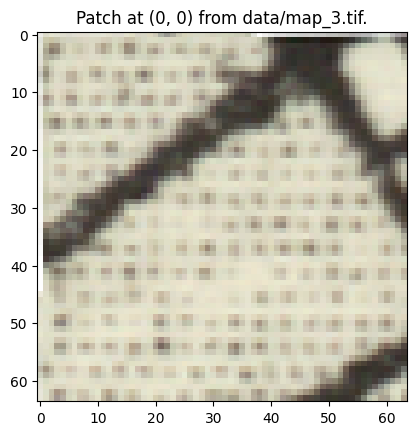

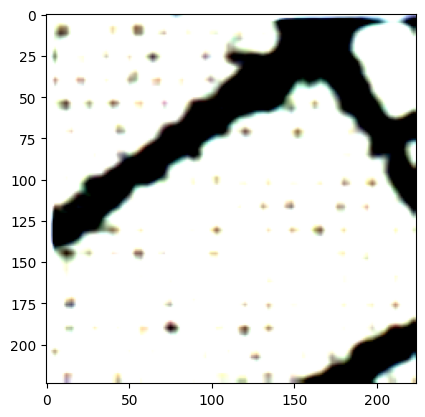

In [31]:
mclnn = MapCLNN()
patch = patch_dataset[0][0]
patch.show()
img = mclnn.img_to_resnet(patch.patch)

fig, ax = plt.subplots()
np_img = np.moveaxis(img.numpy(), 0, -1)
ax.imshow(np_img)
plt.show()

vector = mclnn.resnet(img[None,:])

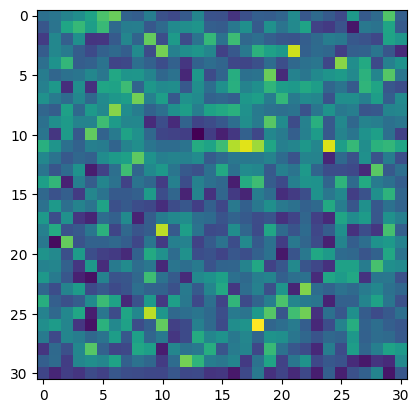

In [37]:
fig, ax = plt.subplots()
ax.imshow(vector.detach().numpy()[0][:961].reshape(31,31))
plt.show()